In [1]:
import numpy as np
import sklearn as sk
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

<a name='list'></a>
### [1. Data preprocessing](#1)
#### &nbsp;&nbsp;&nbsp; [1.1 Missing values preprocessing](#1-1)
#### &nbsp;&nbsp;&nbsp; [1.1 Feature selection](#1-2)
#### &nbsp;&nbsp;&nbsp; [1.3 Data split and Resampling](#1-3)

### [2. Performance using a single model](#2)
#### &nbsp;&nbsp;&nbsp;[2.1 Linear regression](#2-1)
#### &nbsp;&nbsp;&nbsp;[2.2 Ridge regression](#2-2)
#### &nbsp;&nbsp;&nbsp;[2.3 Random forests for regression](#2-3)
#### &nbsp;&nbsp;&nbsp;[2.4 Gradient tree boosting for regression](#2-4)

### [3. Performance using a combination of two models](#3)
#### &nbsp;&nbsp;&nbsp;[3.1 Binary Classification](#3-1)
#### &nbsp;&nbsp;&nbsp;[3.2 Regression](#3-2)

### [4. Report the performance of the best models over the test set](#4)
### [5. Solution presentation](#5)
### [6. Ensemble function](#6)

<a name='1'></a>
# 1. Data preprocessing

In [132]:
#import data
df = pd.read_csv('train.csv')
df.head()

,Row_ID,Household_ID,Vehicle,Calendar_Year,Model_Year,Blind_Make,Blind_Model,Blind_Submodel,Cat1,Cat2,...,Var5,Var6,Var7,Var8,NVCat,NVVar1,NVVar2,NVVar3,NVVar4,Claim_Amount
0,2718481,1933325,3,2006,1997,R,R.20,R.20.6,B,?,...,-1.054747,-1.164837,-0.812472,-0.581756,N,-0.23153,-0.266117,2.715490,-0.251419,104.597500
1,6717427,4297298,1,2006,1997,BF,BF.35,BF.35.1,F,?,...,-1.149901,-1.299354,-1.193388,-1.323992,N,-0.23153,2.783616,-0.272337,-0.251419,0.000000
2,7218252,4708245,1,2006,2000,M,M.16,M.16.1,B,C,...,-0.775231,-1.467792,-0.947636,-0.914860,F,-0.23153,-0.266117,-0.272337,-0.251419,0.000000
3,8048505,5136981,7,2007,2003,BH,BH.22,BH.22.0,B,C,...,-0.751442,-0.378792,-0.689596,0.730640,M,-0.23153,-0.266117,-0.272337,-0.251419,0.000000
4,3209482,2151306,5,2006,2001,BW,BW.167,BW.167.0,I,C,...,0.461775,1.451805,1.411586,0.977104,B,-0.23153,-0.266117,-0.272337,-0.251419,0.615937


In [133]:
# separate columns into categorical group and numerical group
categorical_column = df.select_dtypes(include=['object']).columns
numerical_column =  df.select_dtypes(include=['int64','float64']).columns

<a name='1-1'></a>
### 1.1 Missing values preprocessing

We scan through the data set and print out the missing value of each column. There is no missing value in numerical feature.Some categorical features miss a lot of value (`Cat2`,`Cat4`,`Cat5`,`Cat7`). These columns even miss over 30% of values. Thus,these columns will be discarded.

In [134]:
# the number of the total dataset
N = df.shape[0]
missing_data_con_info= []
missing_data_dis_info= []
for column_name in categorical_column:
    num = df[df[column_name]=='?'].shape[0]/N
    missing_data_dis_info.append([column_name,num])
    
for column_name in numerical_column:
    num = df[df[column_name]==np.NaN].shape[0]/N
    missing_data_con_info.append([column_name,num])
    
missing_data_con_info = pd.DataFrame(missing_data_con_info,columns=['column', 'proportion of missing continuous data'])


missing_data_dis_info = pd.DataFrame(missing_data_dis_info,columns=['column', 'proportion of missing discrete data'])
missing_data_dis_info.sort_values(by=['proportion of missing discrete data'],ascending=False),missing_data_con_info.sort_values(by=['proportion of missing continuous data'],ascending=False)


(            column  proportion of missing discrete data
 9             Cat7                             0.549333
 7             Cat5                             0.433267
 6             Cat4                             0.432833
 4             Cat2                             0.353033
 13           Cat11                             0.001933
 8             Cat6                             0.001667
 3             Cat1                             0.001667
 15          OrdCat                             0.000633
 0       Blind_Make                             0.000500
 1      Blind_Model                             0.000500
 2   Blind_Submodel                             0.000500
 5             Cat3                             0.000367
 12           Cat10                             0.000333
 10            Cat8                             0.000067
 11            Cat9                             0.000000
 14           Cat12                             0.000000
 16           NVCat            

In [135]:
# replace missing value
categorical_column = df.select_dtypes(include=['object']).columns
miss_value_dict = {}
for c_col in categorical_column:
    miss_value_dict[c_col] = df[c_col].mode()[0]
    df[c_col].fillna(df[c_col].mode()[0],inplace= True)
    df[c_col].replace('?',df[c_col].mode()[0],inplace= True)

<a name='1-2'></a>
### 1.2 Feature selection

In this part, we will evaluate the features. Firstly, we will compute the covariance matrix of numerical features. Then, we will plot counts of categorical values. We will select the categorical feature that does not contain too much categories.

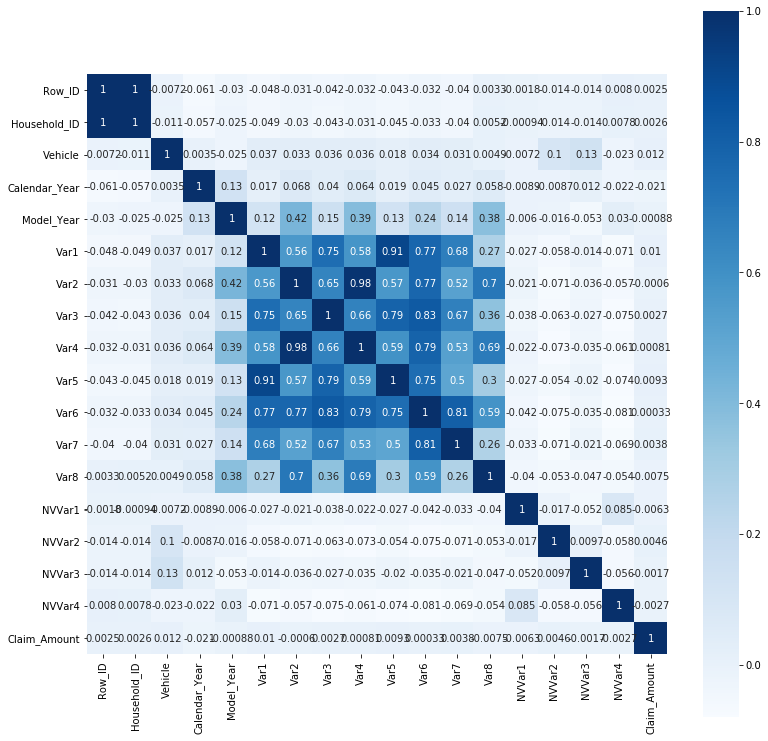

In [136]:
df_corr = df.corr()
plt.subplots(figsize=(13,13))
sns.heatmap(df_corr, annot=True, vmax=1, square=True, cmap="Blues")

Some covariances of `Var*` are over 0.8 which means some `Var*` are strongly related. In the graphs below, we can observe that the relationship between some values is strong. For example, `Var2` and `Var4` roughly show a similar scatter graph. Hence, we can use some of `Var*` to represent remaining features in `Var*`. `House_ID` and `Row_ID` are dependent because the covariance of `House_ID` and `Row_ID` is 1. Also, `Row_ID` is an useless features in this case because `Row_ID` dose not tell any information. Thus, both `House_ID` and `Row_ID` should be discarded.

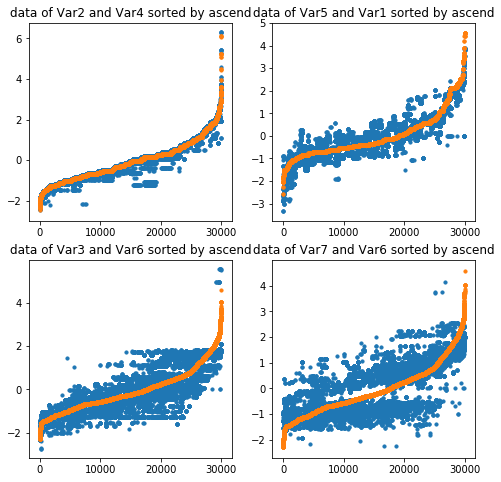

In [137]:
plt.subplots(nrows=2,ncols=2,figsize=(8,8))
varlist = [['Var2','Var4'],['Var5','Var1'],['Var3','Var6'],['Var7','Var6']]
for i,varlistitem in enumerate(varlist):
    plot_index = df[varlistitem[1]].sort_values().index.to_numpy()
    n= plot_index.shape[0]
    plt.subplot(2,2,i+1)
    plt.scatter(np.arange(n),df.iloc[plot_index][varlistitem[0]], s=10)
    plt.scatter(np.arange(n),df.iloc[plot_index][varlistitem[1]], s=10)
    title='data of '+varlistitem[0]+' and '+varlistitem[1]+' sorted by ascend'
    plt.title(title)

Text(0.5, 1.0, 'data of Row_ID and Household_ID sorted by ascend')

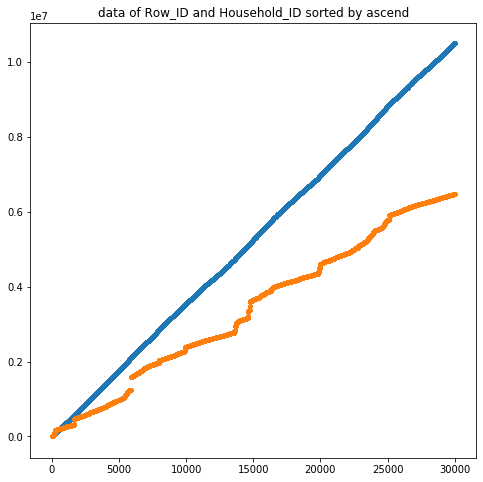

In [138]:
index = df['Household_ID'].sort_values().index.to_numpy()
n= index.shape[0]
plt.subplots(figsize=(8,8))
plt.scatter(np.arange(n),df.iloc[index]['Row_ID'], s=10)
plt.scatter(np.arange(n),df.iloc[index]['Household_ID'], s=10)
plt.title('data of Row_ID and Household_ID sorted by ascend')

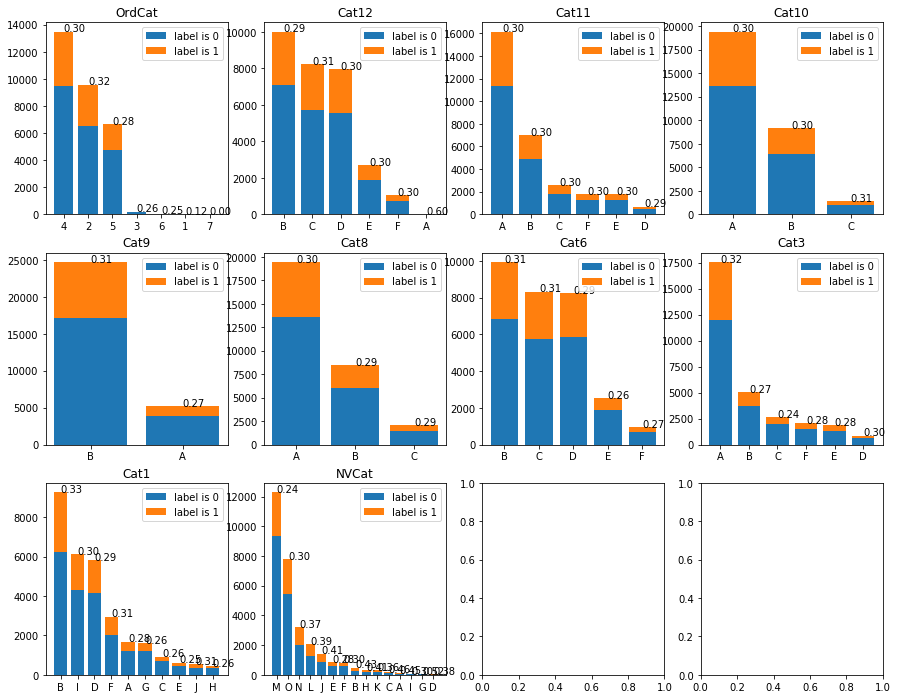

In [139]:
fig, ax = plt.subplots(nrows=3,ncols=4,figsize=(15,12))
pos_df = df[df['Claim_Amount']>0]
neg_df = df[df['Claim_Amount']==0]
plot_categorical_column=['OrdCat','Cat12','Cat11','Cat10','Cat9','Cat8','Cat6','Cat3','Cat1','NVCat']
for i,item in enumerate(plot_categorical_column):
    value_count = df[item].value_counts()
    value_count_dict = {ind:value_count[ind] for ind in value_count.index}
    xlen = value_count.shape[0]
    neg_values = [neg_df[item].value_counts().get(ckey,0) for ckey in value_count_dict.keys()]
    pos_values = [pos_df[item].value_counts().get(ckey,0) for ckey in value_count_dict.keys()]
    plt.subplot(3,4,i+1)
    plt.bar(value_count_dict.keys(),neg_values,label='label is 0')
    plt.bar(value_count_dict.keys(),pos_values,bottom=neg_values,label='label is 1')
    for k,p,n in zip(value_count_dict.keys(),pos_values,neg_values):
        val = p/(p+n)
        plt.text(k,p+n,'%.2f' %val)
    plt.title(item)
    plt.legend()

In [140]:
Col_selection = ['Calendar_Year','Model_Year','Var1','Var5','Var3','Var7','Var8','Vehicle','NVVar1','NVVar2','NVVar3','NVVar4','Cat9','Cat10','Cat11','Cat8','Cat12','Cat6','Cat3','Claim_Amount']
df = df[Col_selection]

<a name='1-3'></a>
### 1.3 Data split and Resampling

In this case, labels are imbalanced. There are 21000 labels marked as 0 and only 9000 labels are non-zero. If we use the data without resampling the model will be short of classify non-zero samples. In my assignment, I will use the over-sampling as my resampling method. Oversampling is only implemented on the train set which means some of data in training set will be repeated and the data of test set will never be the same as the data in training set.

In [141]:
#transform 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
full_trans = ColumnTransformer([
    ('num', StandardScaler(), numerical_column),
    ('cat', OneHotEncoder(), categorical_column),
])

In [142]:
# split the dataframe  
#return train_set and test_set
def split_df_data(df, train_size = 0.9):
    import numpy as np
    df_size = df.shape[0]
    train_df_size = int(df_size*train_size)
    df_index = df.index.values
    np.random.shuffle(df_index)
    return df.iloc[:train_df_size,:], df.iloc[train_df_size:,:]

In [143]:
train_set, test_set = split_df_data(df)
train_set_copy = train_set.copy()

In [144]:
#  data resampling
def train_data_resampling_and_transform(df, method = 'oversample'):
    from sklearn.utils import resample,shuffle
    
    label = df['Claim_Amount']
    
    pos_size = (df[df['Claim_Amount']>0].index.values).shape[0]
    neg_size = df.shape[0] - pos_size
    pos_sample = df[df['Claim_Amount']>0]
    neg_sample = df[df['Claim_Amount']==0]
    pos_label = label[label>0]
    neg_label = label[label==0]
    
    pos_sample, pos_label = resample(pos_sample, pos_label, n_samples=neg_size )
    neg_sample, neg_label = neg_sample.to_numpy(), neg_label.to_numpy()
    pos_label = pos_label.to_numpy().reshape((-1,1))
    neg_label = neg_label.reshape((-1,1))
    
    posdata = np.concatenate((pos_sample, pos_label),axis=1)
    negdata = np.concatenate((neg_sample,neg_label),axis=1)
    alldata = np.concatenate((posdata, negdata),axis=0)
    
    alldata = shuffle(alldata)
    return alldata[:,:-2], alldata[:,-1]

In [145]:
train_set, train_label = train_data_resampling_and_transform(train_set)

In [146]:
# data transform
def data_transform_onehot_standardize(data,all_col,categorical_column,numerical_column):
    from sklearn.compose import ColumnTransformer
    from sklearn.preprocessing import OneHotEncoder,StandardScaler
    import pandas as pd
    
    df_data = pd.DataFrame(data= data, columns=all_col)
    transformer = ColumnTransformer([
        ('num', StandardScaler(), numerical_column),
        ('cat', OneHotEncoder(),categorical_column),
        
    ])
    data_tramsformed = transformer.fit_transform(df_data)
    return data_tramsformed, transformer

In [147]:
all_columns = df.drop(columns=['Claim_Amount']).columns
categorical_column = df.drop(columns=['Claim_Amount']).select_dtypes(include=['object']).columns
numerical_column =  df.drop(columns=['Claim_Amount']).select_dtypes(include=['int64','float64']).columns
train_data_transformed, transformer_1 = data_transform_onehot_standardize(train_set, all_columns, categorical_column, numerical_column)

In [148]:
test_data = test_set.drop(columns=['Claim_Amount'])
test_label = test_set['Claim_Amount']
test_data_transformed = transformer_1.transform(test_data)

<br>[go back to the list](#list)

<a name='2'></a>
# 2. Performance using a single model

In [2]:
#model design
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor,GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.linear_model import LinearRegression, Ridge, LassoCV
from sklearn.model_selection import train_test_split

<a name='2-1'></a>
### 2.1 Linear regression

In [59]:
lr = LinearRegression()
# lr_params = {
#     'n_jobs':[-1]
# }
lr_gr = GridSearchCV(estimator=lr,param_grid={}, cv=5, n_jobs=-1)
lr_gr.fit(train_data_transformed, train_label)
lr_gr.best_params_ 

{'n_jobs': -1}

In [60]:
lr_pred = lr_gr.predict(test_data_transformed)
np.sqrt(mean_squared_error(lr_pred, test_label))

240.94167745418173

<a name='2-2'></a>
### 2.2 Ridge regression

In [162]:
ridge = Ridge(alpha=1.5)
ridge_params = {
#     'alpha':[0.7,1,1.5]
}
ridge_gr = GridSearchCV(estimator=ridge,param_grid={}, cv=5)
ridge_gr.fit(train_data_transformed, train_label)
ridge_gr.best_params_ 

{}

In [163]:
ridge_pred =ridge_gr.predict(test_data_transformed)
np.sqrt(mean_squared_error(ridge_pred, test_label))

240.43081031933764

<a name='2-3'></a>
### 2.3 Random forests for regression

In [166]:
rfr = RandomForestRegressor(max_depth=20,min_samples_leaf=4, min_samples_split=8,n_jobs= -1)
rfr_params={
#     'max_depth':[10,15,20],
#     'min_samples_split':[8,10,20],
#     'min_samples_leaf':[4,8,12],
}
rfr_gr = GridSearchCV(estimator=rfr,param_grid=rfr_params,cv=5)
rfr_gr.fit(train_data_transformed, train_label)
rfr_gr.best_params_ 

{'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 8}

In [167]:
rfr_pred = rfr_gr.predict(test_data_transformed)
np.sqrt(mean_squared_error(rfr_pred, test_label))

250.22205441713947

<a name='2-4'></a>
### 2.4 Gradient tree boosting for regression

In [26]:
gbr = GradientBoostingRegressor(max_depth= 10,min_samples_leaf=2, min_samples_split= 2)
gbr_params={
#     'max_depth':[3,6,10],
#     'min_samples_split':[2,8,16],
#     'min_samples_leaf':[2,4,8],
}
gbr_gr = GridSearchCV(estimator=gbr,param_grid=gbr_params,cv=5, n_jobs=-1)
gbr_gr.fit(train_data_transformed, train_label)
gbr_gr.best_params_ 

{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2}

In [27]:
gbr_pred = gbr_gr.predict(test_data_transformed)
np.sqrt(mean_squared_error(gbr_pred, test_label))

253.05410418988737

<br>[go back to the list](#list)

<a name='3'></a>
# 3.Performance using a combination of two models

In [150]:
#binary encoding
train_label_binary, test_label_binary = train_label.copy(), test_label.copy()

train_label_binary[train_label_binary>0] = 1
test_label_binary[test_label_binary>0] = 1

train_label_binary = train_label_binary.astype('int')
test_label_binary = test_label_binary.astype('int')


<a name='3-1'></a>
### 3.1 Binary Classification

<a name='rfc'></a>
<b>RandomForestClassifier</b>

In [151]:
rfc = RandomForestClassifier(max_depth=16, min_samples_leaf=4, min_samples_split=10)
rfc_params = {
#     'max_depth':[8,12,16],
#     'min_samples_split': [10,20,30],
#     'min_samples_leaf':[4,8,12],
}
rfc_gr = GridSearchCV(estimator=rfc, param_grid={}, cv=5, n_jobs=-1)
rfc_gr.fit(train_data_transformed, train_label_binary)
rfc_gr.best_params_, rfc_gr.best_score_

({}, 0.7028843609420481)

({'max_depth': 16, 'min_samples_leaf': 4, 'min_samples_split': 10},
 0.706286836935167)

In [152]:
confusion_matrix(rfc_gr.predict(test_data_transformed), test_label_binary)

array([[1535,  552],
       [ 570,  343]], dtype=int64)

<a name='dtc'></a>
<b>DecisionTreeClassifier</b>

In [153]:
dtc = DecisionTreeClassifier(max_depth=16, min_samples_leaf=4, min_samples_split=10)
dtc_params = {
#     'max_depth':[8,12,16],
#     'min_samples_split': [10,20,30],
#     'min_samples_leaf':[4,8,12],
}
dtc_gr = GridSearchCV(estimator=dtc, param_grid={}, cv=5, n_jobs=-1)
dtc_gr.fit(train_data_transformed, train_label_binary)
dtc_gr.best_params_,dtc_gr.best_score_ 

({}, 0.601693569727441)

({'max_depth': 16, 'min_samples_leaf': 4, 'min_samples_split': 10},
 0.6072130227336515)

In [154]:
confusion_matrix(dtc_gr.predict(test_data_transformed), test_label_binary)

array([[1519,  629],
       [ 586,  266]], dtype=int64)

<a name='gbc'></a>
<b>GradientBoostingClassifier</b>

In [176]:
gbc = GradientBoostingClassifier(max_depth=16, min_samples_leaf=4, min_samples_split=10)
# gbc_params = {
#      'max_depth':[8,12,16],
#      'min_samples_split': [10,20,30],
#      'min_samples_leaf':[4,8,12],
# }
gbc_gr = GridSearchCV(estimator=gbc, param_grid={}, cv=5, n_jobs=-1)
gbc_gr.fit(train_data_transformed, train_label_binary)
gbc_gr.best_params_,gbc_gr.best_score_ 

({'max_depth': 16, 'min_samples_leaf': 4, 'min_samples_split': 10},
 0.8209843874040752)

({'max_depth': 16, 'min_samples_leaf': 4, 'min_samples_split': 10},
 0.8209843874040752)

In [177]:
confusion_matrix(gbc_gr.predict(test_data_transformed), test_label_binary)

array([[1696,  668],
       [ 409,  227]], dtype=int64)

<a name='3-2'></a>
### 3.2 Regression

In [155]:
#regression
test_label=test_label.values
non_zero_train_index = np.where(train_label>0)[0]
non_zero_test_index = np.where(test_label>0)[0]

train_data_transformed_non_zero, train_label_non_zero = train_data_transformed[non_zero_train_index,:], train_label[non_zero_train_index]
test_data_transformed_non_zero, test_label_non_zero = test_data_transformed[non_zero_test_index,:], test_label[non_zero_test_index]

In [156]:
regressor = Ridge()
regressor.fit(train_data_transformed_non_zero,train_label_non_zero)
regressor_pred = regressor.predict(test_data_transformed_non_zero)
np.sqrt(mean_squared_error(regressor_pred,test_label_non_zero))

406.6555989896969

<b>test the intregrated model by using the validation data used in Step 2</b>

<b>RandomForestClassifier & Ridge Regression</b>

In [191]:
intergrated_res_rfc = rfc_gr.predict(test_data_transformed)
intergrated_res_rfc  = intergrated_res_rfc.astype('float64')
regression_index_rfc = np.where(intergrated_res_rfc>0)
intergrated_res_rfc[regression_index_rfc] = regressor.predict(test_data_transformed[np.where(intergrated_res_rfc>0)])

In [192]:
np.sqrt(mean_squared_error(intergrated_res_gbc, test_label))

246.67867185867084

<b>GradientBoostingClassifier & Ridge Regression</b>

In [187]:
intergrated_res_gbc = gbc_gr.predict(test_data_transformed)
intergrated_res_gbc  = intergrated_res_gbc.astype('float64')
regression_index_gbc = np.where(intergrated_res_gbc>0)
intergrated_res_gbc[regression_index_gbc] = regressor.predict(test_data_transformed[np.where(intergrated_res_gbc>0)])

In [188]:
np.sqrt(mean_squared_error(intergrated_res_rfc, test_label))

243.34896353958698

<br>[go back to the list](#list)

<a name='4'></a>
# 4. Report the performance of the best models over the test set

<b>(a)</b> From the RMSE of Step 2, we observe that the RMSE of `Ridge Regression` is the smallest which means `Ridge Regression` perform best among 4 regression models.

|      | LinearRegression   | Ridge Regression   | RandomForestRegressor | GradientBoostingRegressor |
|------|--------------------|--------------------|-----------------------|---------------------------|
| RMSE | 240.94167745418173 | 240.43081031933764 | 250.22205441713947    | 253.05410418988737        |
<br>

<b>(b)</b> In Step 3, the performance of `RandomForestClassifier` is better than `DecisionTreeClassifier`. The confusion matrix of `RandomForestClassifier` shows that the precision of 0 label is around 75%, however, the precision of 1 label is only 37.7%. It means the model can classify the category `0` with a pretty high accruacy but it performs badly on classify category `1`. The accuracy of `DecisionTreeClassifier` in test set is 59.5% so the performance of `DecisionTreeClassifier` is very bad. `GradientBoostingClassifier` runs 64% accuray on test set which is the highest accuracy (`RandomForestClassifier` 62.6%, `DecisionTreeClassifier` 59.5%). <br><br>
Although `GradientBoostingClassifier` performs best, the confusion matrix of `GradientBoostingClassifier` shows that the precision of label 1 is only 25%.

|                            | training set | test set  |
|----------------------------|--------------|-----------|
| [RandomForestClassifier](#rfc)     | 70.288%      | 62.6%     |
| [DecisionTreeClassifier](#dtc)    | 60.169%      | 59.5%     |
| [GradientBoostingClassifier](#gbc) | 82.098%      | 64%       |
<br>


<b>(c)</b> Finally, we made a comparison between `GradientBoostingClassifier` and `RandomForestClassifier`. The RMSE of the integrated model with `GradientBoostingClassifier`(243.34) is lower than the model contains `RandomForestClassifier`(246.67). Hence, I chose `GradientBoostingClassifier` as the binary model and `Ridge` regressor as the regression model.

|      | GradientBoostingClassifier & Ridge | RandomForestClassifier & Ridge |
|------|------------------------------------|--------------------------------|
| RMSE | 243.34896353958698                 | 246.67867185867084             |
<br>

<br>[go back to the list](#list)

<a name='5'></a>
# 5. Solution presentation


<b>(a)</b> The data set used in this assignment is imbalanced, so we have to use some sampling skill to process our data set. In my assignment, I used the over-sampling to expand my data which is greater than 0. Also, I compared it with the model that does not use the over-sampling. The non-sampling model has 70% accuracy but the model with over-sampling only has 64%. Although the non-sampling model performs better on accuracy its confusion matrix tells us it probably marks all the test data as category `0`. Hence, when the data set is an imbalance we should use resampling skills to handle the data set.
<br><br>
confusion matrix of non-sampling model

|                     | Zero labels | Non-zero lables |
|---------------------|-------------|-----------------|
| Zero prediction     | 4187        | 1718            |
| Non-zero prediction | 47          | 48              |

<b>(b)</b> It seems that the `RMSE` of my integrated prediction(249.34) is even greater than the Ridge regression model(240.43) in Step 2. However, the Ridge model cannot classify the category `0`. As the scatter graph shown below, the Ridge model has no ability to recognize the `0` label data. In this case, it means everyone can get insurance. This is unreasonable. If the binary classification of my model is imporved, the accurcy of my model will also be increaced.
<br>

Text(0.5, 1.0, 'my prediction result sorted by ascending')

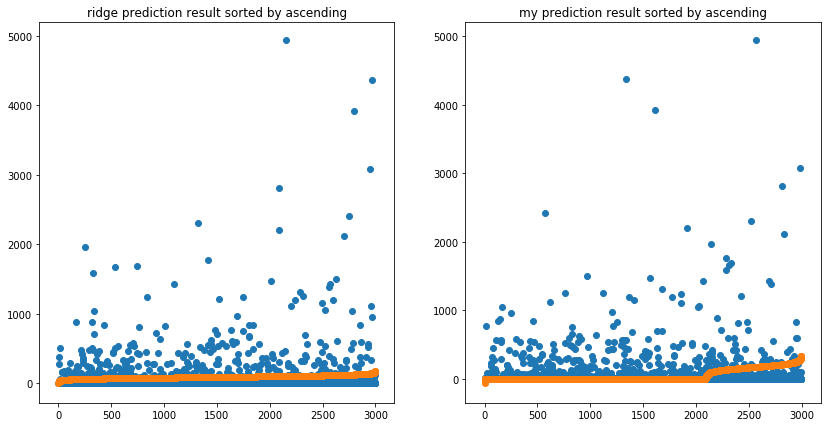

In [197]:
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
ridge_sorted_index = np.argsort(ridge_pred)
plt.scatter(np.arange(test_label.shape[0]),test_label[ridge_sorted_index])
plt.scatter(np.arange(test_label.shape[0]),ridge_pred[ridge_sorted_index])
plt.title('ridge prediction result sorted by ascending')
plt.subplot(1,2,2)
my_sorted_index = np.argsort(intergrated_res)
plt.scatter(np.arange(test_label.shape[0]),test_label[my_sorted_index])
plt.scatter(np.arange(test_label.shape[0]),intergrated_res[my_sorted_index])
plt.title('my prediction result sorted by ascending')

<b>(c)</b> The performance of `Decision Tree` is significantly affected by pre-turning. If the `Decision Tree` run with default hyper-parameters such as `min_samples_split=2`, `min_samples_leaf=1`, the `Decision Tree` might perform very well on training set but its accuracy of test set could be very low. That is because such hyper-parameters will cause over-fitting. Thus we should tune parameters. Sometimes, it might lower the accuracy of train set but it can increase the generalization ability of the model.

<b>(d)</b> Features selection is vital since a proper selection can improve the performance of the model. In my assignment, I have tried to just use 5 features but the accuracy of prediction is very low. When I chose more features(19 features), the accuracy significantly increased.

<br>[go back to the list](#list)

<a name='6'></a>
# 6. Ensemble function

In [194]:
def Claim_Amount_predict(raw_data,miss_value_dict):
    raw_data_categorical_column = raw_data.select_dtypes(include=['object']).columns
    for c_col in raw_data_categorical_column:
        raw_data[c_col].fillna(miss_value_dict[c_col],inplace= True)
        raw_data[c_col].replace('?',miss_value_dict[c_col],inplace= True)
        
    data = transformer_1.transform(raw_data)
    res = gbc_gr.predict(data)
    res = res.astype('float64')
    regression_index = np.where(res>0)
    res[regression_index] = regressor.predict(data[np.where(res>0)])
    return res

In [195]:
test_csv = pd.read_csv('./data/test.csv')
cap_res = Claim_Amount_predict(test_csv,miss_value_dict)

C:\Users\physe\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


In [196]:
cap_res.tolist()

[0.0, 0.0, 168.1446591952682, 0.0, 0.0, 0.0, 0.0, 0.0, 194.51239467741843]